<a href="https://colab.research.google.com/github/c-brun/traffic-sign-detection/blob/main/2_few_shot_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Few-shot learning expansion of the project based on the German Traffic Sign Detection Benchmark (GTSDB)

# Plan

1. Introduction and Problem Statement
2. Setup and Environment Preparation
3. Data Loading
4. Data Exploration
5. Train, Validation and Test Split
6. Model training
7. Model Evaluation

Conclusion

#1. Introduction and Problem Statement




* Please, refer to the original notebook. This is an expansion of the base case to include few-shot learning only on the best model on standard cases which is RT-DETR.

#2. Setup and Environment Preparation

* We mount Google Drive and import the basic libraries needed for the project.

* We specify the path of the images and annotations.

* We also specify the mapping between class IDs and descriptions.

In [ ]:
# Import necessary libraries
import locale
locale.getpreferredencoding = lambda: 'UTF-8'

In [ ]:
#!pip install -U openmim
#!mim install mmcv-full

!pip install tqdm
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 976.9/976.9 kB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninsta

In [ ]:
import os
import cv2
import numpy as np
import random
import yaml
import shutil
import time
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import pandas as pd
from tqdm import tqdm
from matplotlib.colors import to_rgba
from matplotlib.patches import Patch
from google.colab import drive
import torch
from ultralytics import YOLO, RTDETR
from typing import List, Dict
# Mount Google Drive if not already mounted
drive.mount('/content/drive', force_remount=True)

# -----------------------------------------------------------------------------------------------------------------------------

# Define mapping of class IDs to descriptions and categories (based on ReadMe.txt)
class_info = {
    0: ("Speed limit 20", "prohibitory"),
    1: ("Speed limit 30", "prohibitory"),
    2: ("Speed limit 50", "prohibitory"),
    3: ("Speed limit 60", "prohibitory"),
    4: ("Speed limit 70", "prohibitory"),
    5: ("Speed limit 80", "prohibitory"),
    6: ("Restriction ends 80", "other"),
    7: ("Speed limit 100", "prohibitory"),
    8: ("Speed limit 120", "prohibitory"),
    9: ("No overtaking", "prohibitory"),
    10: ("No overtaking (trucks)", "prohibitory"),
    11: ("Priority at next intersection", "danger"),
    12: ("Priority road", "other"),
    13: ("Give way", "other"),
    14: ("Stop", "other"),
    15: ("No traffic both ways", "prohibitory"),
    16: ("No trucks", "prohibitory"),
    17: ("No entry", "other"),
    18: ("Danger", "danger"),
    19: ("Bend left", "danger"),
    20: ("Bend right", "danger"),
    21: ("Bend", "danger"),
    22: ("Uneven road", "danger"),
    23: ("Slippery road", "danger"),
    24: ("Road narrows", "danger"),
    25: ("Construction", "danger"),
    26: ("Traffic signal", "danger"),
    27: ("Pedestrian crossing", "danger"),
    28: ("School crossing", "danger"),
    29: ("Cycles crossing", "danger"),
    30: ("Snow", "danger"),
    31: ("Animals", "danger"),
    32: ("Restriction ends", "other"),
    33: ("Go right", "mandatory"),
    34: ("Go left", "mandatory"),
    35: ("Go straight", "mandatory"),
    36: ("Go right or straight", "mandatory"),
    37: ("Go left or straight", "mandatory"),
    38: ("Keep right", "mandatory"),
    39: ("Keep left", "mandatory"),
    40: ("Roundabout", "mandatory"),
    41: ("Restriction ends (overtaking)", "other"),
    42: ("Restriction ends (overtaking trucks)", "other")
}

Mounted at /content/drive


In [ ]:
# Define paths
base_path = "/content/drive/My Drive"
annotations_path = os.path.join(base_path, "annotations/gt.txt")
converted_path = os.path.join(base_path, "convert_images")

#3. Data Loading

We explain in the section 4 where we explore the data why we split the set between a standard, augmentation and few shot classes.

In [ ]:
# Import necessary libraries
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

# Global Configuration Settings
x = 13 # Standard class threshold

INCLUDE_STANDARD_DATA = True
INCLUDE_FEW_SHOT_CLASSES = []

YOLO_IMG_SIZE = 640
DETR_LONG_SIDE = 800

# LabelMapper class
class LabelMapper:
    def __init__(self):
        self.label_to_id = {}
        self.id_to_label = {}

    def fit(self, classes):
        self.label_to_id = {label: idx for idx, label in enumerate(classes)}
        self.id_to_label = {idx: label for label, idx in self.label_to_id.items()}

    def transform(self, labels):
        # Handle both single values and lists
        if isinstance(labels, (list, tuple, np.ndarray)):  # Check if iterable
            return [self.label_to_id[label] for label in labels]
        else:  # Single value
            return self.label_to_id[labels]

    def inverse_transform(self, ids):
        # Handle both single values and lists
        if isinstance(ids, (list, tuple, np.ndarray)):
            return [self.id_to_label[id] for id in ids]
        else:
            return self.id_to_label[ids]

# Load function
def load_dataset_parameterized(x=x):
    """
    Load dataset with mapping to sequential IDs for included classes.
    Returns: (standard_data, augmentation_data, few_shot_data, mapper)
    """
    with open(annotations_path, 'r') as f:
        annotations = f.readlines()

    # First pass: Class analysis
    class_counts = defaultdict(int)
    for anno in annotations:
        parts = anno.strip().split(';')
        if len(parts) == 6:
            class_counts[int(parts[5])] += 1

    # Print class distribution
    print("\nOriginal Class Distribution:")
    for cls, count in sorted(class_counts.items()):
        print(f"Class {cls}: {count} samples")

    # Categorize classes
    standard_classes = [c for c, cnt in class_counts.items() if cnt >= x]
    few_shot_classes = [c for c, cnt in class_counts.items() if cnt < x]

    # Determine included classes
    included_classes = []
    if INCLUDE_STANDARD_DATA:
        included_classes.extend(standard_classes)
    if INCLUDE_FEW_SHOT_CLASSES:
        included_classes.extend([c for c in few_shot_classes
                               if c in INCLUDE_FEW_SHOT_CLASSES or str(c) in INCLUDE_FEW_SHOT_CLASSES])

    # Create mapper for included classes - using sorted to ensure consistent mapping
    mapper = LabelMapper()
    mapper.fit(sorted(included_classes))

    # Second pass: Build datasets with mapping
    standard_data, few_shot_data = [], []
    processed_images = set()

    for anno in annotations:
        parts = anno.strip().split(';')
        if len(parts) != 6:
            continue

        img_file = parts[0]
        coords = [int(parts[i]) for i in range(1, 5)]
        original_class = int(parts[5])

        # Skip classes not in included set
        if original_class not in included_classes:
            continue

        # Create mapped annotation
        annotation = {
            'img_path': os.path.join(converted_path, img_file.replace('.ppm', '.png')),
            'bbox': coords,
            'original_class': original_class,
            'class_id': mapper.transform(original_class)  # Sequential ID
        }

        # Categorize based on original class counts
        if original_class in standard_classes:
            standard_data.append(annotation)
        else:
            few_shot_data.append(annotation)

        processed_images.add(annotation['img_path'])

    print(f"Class Mapping: {mapper.label_to_id}")
    return standard_data, few_shot_data, mapper

In [ ]:
# Import Albumentations
import albumentations as A
import cv2
import os
import numpy as np
from tqdm import tqdm
import random
from collections import defaultdict

def get_all_few_shot_classes(annotations_path, x=13):
    """
    Helper function to get all few-shot classes from the dataset.
    Use this to populate INCLUDE_FEW_SHOT_CLASSES.

    Args:
        annotations_path: Path to annotations file
        x: Threshold for few-shot classes

    Returns:
        List of all few-shot class IDs
    """
    with open(annotations_path, 'r') as f:
        annotations = f.readlines()

    # Count occurrences of each class
    class_counts = defaultdict(int)
    for anno in annotations:
        parts = anno.strip().split(';')
        if len(parts) == 6:
            class_counts[int(parts[5])] += 1

    # Get classes with fewer than x samples
    few_shot_classes = [c for c, cnt in class_counts.items() if cnt < x]

    print(f"Found {len(few_shot_classes)} few-shot classes: {few_shot_classes}")
    return few_shot_classes

def create_simple_transforms():
    """
    Create a simplified augmentation pipeline for traffic signs.
    """
    transform = A.Compose([
        # Basic geometric transformations
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=15, p=0.7),
        A.Affine(rotate=(-10, 10), p=0.5),

        # Basic color adjustments
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.7),
        A.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=20, val_shift_limit=20, p=0.5),

        # Simple blur
        A.GaussianBlur(blur_limit=3, p=0.2),

        # Weather effects (using only compatible parameters)
        A.RandomFog(p=0.2),
        A.RandomRain(p=0.2),
    ], bbox_params=A.BboxParams(
        format='pascal_voc',  # xmin, ymin, xmax, ymax
        label_fields=['class_labels'],
        min_visibility=0.5
    ))

    return transform

def augment_few_shot_data_simple(few_shot_data, num_augmentations_per_sample=5):
    """
    A simpler, more robust approach to augment few-shot data.
    Instead of extracting and pasting signs, this directly augments each image.

    Args:
        few_shot_data: List of dictionaries containing few-shot data
        num_augmentations_per_sample: Number of augmented versions to create per original sample

    Returns:
        List of augmented data samples in the same format as the original data
    """
    transform = create_simple_transforms()
    augmented_data = []

    # Process each few-shot sample
    for item in tqdm(few_shot_data, desc="Augmenting few-shot samples"):
        try:
            # Read the original image
            image = cv2.imread(item['img_path'])
            if image is None:
                print(f"Warning: Could not read image {item['img_path']}")
                continue

            # Convert BGR to RGB
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Extract bbox and class info
            bbox = item['bbox']
            class_id = item['class_id']
            original_class = item['original_class']

            # Validate bbox format (must be [x1, y1, x2, y2] with 4 values)
            if len(bbox) != 4:
                print(f"Warning: Invalid bbox format for {item['img_path']}: {bbox}")
                continue

            x1, y1, x2, y2 = bbox

            # Sanity check - make sure the bbox is valid
            if x1 >= x2 or y1 >= y2:
                print(f"Warning: Invalid bbox dimensions for {item['img_path']}: {bbox}")
                continue

            # Create multiple augmentations
            for aug_idx in range(num_augmentations_per_sample):
                try:
                    # Apply augmentation
                    augmented = transform(
                        image=image,
                        bboxes=[bbox],
                        class_labels=[class_id]
                    )

                    # Skip if no bounding boxes were returned
                    if len(augmented['bboxes']) == 0:
                        continue

                    aug_image = augmented['image']
                    aug_bbox = augmented['bboxes'][0]

                    # Create a unique identifier for the augmented image
                    base_name = os.path.basename(item['img_path']).split('.')[0]
                    aug_img_filename = f"aug_{base_name}_{aug_idx}.jpg"
                    aug_img_dir = os.path.join(os.path.dirname(item['img_path']), "augmented")
                    aug_img_path = os.path.join(aug_img_dir, aug_img_filename)

                    # Ensure augmented directory exists
                    os.makedirs(aug_img_dir, exist_ok=True)

                    # Save the augmented image
                    cv2.imwrite(aug_img_path, cv2.cvtColor(aug_image, cv2.COLOR_RGB2BGR))

                    # Add to augmented data
                    augmented_data.append({
                        'img_path': aug_img_path,
                        'bbox': [int(x) for x in aug_bbox],
                        'class_id': class_id,
                        'original_class': original_class
                    })
                except Exception as e:
                    print(f"Error in augmentation loop for {item['img_path']} (idx={aug_idx}): {e}")
                    continue

        except Exception as e:
            print(f"Error processing {item['img_path']}: {e}")
            continue

    return augmented_data

def apply_augmentation_pipeline():
    """
    Function to integrate the augmentation into the existing pipeline.
    This can be called after the original data loading and before creating the dataset splits.
    Uses the simplified augmentation approach.
    """
    # Load original data
    standard_data, few_shot_data, mapper = load_dataset_parameterized(x=x)

    # Helper to include all few-shot classes if needed
    if len(INCLUDE_FEW_SHOT_CLASSES) == 0:
        print("No few-shot classes explicitly included. Use get_all_few_shot_classes() to include them all.")

    # Apply augmentation to few-shot classes
    if INCLUDE_FEW_SHOT_CLASSES:
        # Filter few_shot_data to only include specified classes
        filtered_few_shot = [item for item in few_shot_data
                            if item['original_class'] in INCLUDE_FEW_SHOT_CLASSES
                            or str(item['original_class']) in INCLUDE_FEW_SHOT_CLASSES]

        print(f"\nAugmenting {len(filtered_few_shot)} few-shot samples...")

        # Apply simple augmentation approach
        augmented_data = augment_few_shot_data_simple(
            filtered_few_shot,
            num_augmentations_per_sample=5
        )

        # Combine the datasets
        combined_data = []
        if INCLUDE_STANDARD_DATA:
            combined_data.extend(standard_data)
        combined_data.extend(filtered_few_shot)
        combined_data.extend(augmented_data)

        # Compute augmentation statistics
        orig_class_counts = defaultdict(int)
        aug_class_counts = defaultdict(int)

        for item in filtered_few_shot:
            orig_class_counts[item['class_id']] += 1

        for item in augmented_data:
            aug_class_counts[item['class_id']] += 1

        # Print augmentation statistics
        print("\nAugmentation Statistics:")
        print(f"Original few-shot samples: {len(filtered_few_shot)}")
        print(f"Generated augmented samples: {len(augmented_data)}")
        print(f"Total dataset size: {len(combined_data)}")

        print("\nClass distribution after augmentation:")
        for class_id, count in orig_class_counts.items():
            if aug_class_counts[class_id] > 0:
                orig_class = mapper.id_to_label[class_id]
                print(f"Class {class_id} (original ID: {orig_class}): {count} original + {aug_class_counts[class_id]} augmented = {count + aug_class_counts[class_id]} total")

        # Handle the case where we have few-shot classes with only 1 example
        # This section prevents the StratifiedShuffleSplit error
        problem_classes = [class_id for class_id, count in orig_class_counts.items()
                           if count + aug_class_counts[class_id] < 2]

        if problem_classes:
            print("\nWARNING: The following classes have fewer than 2 samples after augmentation:")
            for class_id in problem_classes:
                orig_class = mapper.id_to_label[class_id]
                print(f"Class {class_id} (original ID: {orig_class}): only {orig_class_counts[class_id] + aug_class_counts[class_id]} samples")

            print("\nHandling these classes by duplicating their samples to have at least 2 per class...")

            # Duplicate samples for these classes to have at least 2
            for item in combined_data[:]:  # Use a copy of the list for iteration
                if item['class_id'] in problem_classes:
                    # Create a copy with a slightly modified path
                    dup_item = item.copy()
                    base_path = item['img_path']
                    dup_path = base_path.replace('.jpg', '_dup.jpg')
                    dup_path = base_path.replace('.png', '_dup.png')
                    if dup_path == base_path:  # No replacement happened
                        dup_path = base_path + '_dup'

                    # Copy the image file
                    try:
                        shutil.copy(base_path, dup_path)
                        dup_item['img_path'] = dup_path
                        combined_data.append(dup_item)
                        aug_class_counts[item['class_id']] += 1
                    except Exception as e:
                        print(f"Warning: Could not duplicate {base_path}: {e}")

        # Create splits from combined data
        train_data, val_data, test_data = create_stratified_split(combined_data)
    else:
        # If no few-shot classes included, just use standard data
        if INCLUDE_STANDARD_DATA:
            train_data, val_data, test_data = create_stratified_split(standard_data)
        else:
            raise ValueError("No data selected: both INCLUDE_STANDARD_DATA and INCLUDE_FEW_SHOT_CLASSES are empty/False")

    return train_data, val_data, test_data

# Example of how to get all few-shot classes for inclusion
def example_usage():
    # First, get all few-shot classes
    all_few_shot_classes = get_all_few_shot_classes(annotations_path)

    # Then update your configuration to include them all
    global INCLUDE_FEW_SHOT_CLASSES
    INCLUDE_FEW_SHOT_CLASSES = all_few_shot_classes

    # Now run the augmentation pipeline
    train_data, val_data, test_data = apply_augmentation_pipeline()

    # Continue with the rest of your code
    # setup_dataset(train_data, val_data, test_data, mapper)

# To use in existing code:
# 1. Replace the original split creation:
#    train_data, val_data, test_data = create_stratified_split(selected_data)
# with:
#    train_data, val_data, test_data = apply_augmentation_pipeline()
#
# 2. To include all few-shot classes, add this before calling apply_augmentation_pipeline:


In [ ]:
INCLUDE_FEW_SHOT_CLASSES = get_all_few_shot_classes(annotations_path)

Found 17 few-shot classes: [40, 39, 21, 27, 36, 37, 34, 0, 24, 20, 29, 16, 19, 41, 31, 42, 32]


In [ ]:
standard_data, few_shot_data, mapper = load_dataset_parameterized()


Original Class Distribution:
Class 0: 4 samples
Class 1: 79 samples
Class 2: 81 samples
Class 3: 30 samples
Class 4: 68 samples
Class 5: 53 samples
Class 6: 19 samples
Class 7: 41 samples
Class 8: 57 samples
Class 9: 41 samples
Class 10: 80 samples
Class 11: 38 samples
Class 12: 85 samples
Class 13: 83 samples
Class 14: 32 samples
Class 15: 15 samples
Class 16: 8 samples
Class 17: 29 samples
Class 18: 38 samples
Class 19: 2 samples
Class 20: 9 samples
Class 21: 5 samples
Class 22: 13 samples
Class 23: 20 samples
Class 24: 5 samples
Class 25: 31 samples
Class 26: 18 samples
Class 27: 3 samples
Class 28: 14 samples
Class 29: 5 samples
Class 30: 16 samples
Class 31: 2 samples
Class 32: 8 samples
Class 33: 16 samples
Class 34: 12 samples
Class 35: 20 samples
Class 36: 9 samples
Class 37: 2 samples
Class 38: 88 samples
Class 39: 6 samples
Class 40: 10 samples
Class 41: 7 samples
Class 42: 11 samples
Class Mapping: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11,

#4. Data Exploration

This section is addressed in the base case. Here all the classes are selected therefore would appear in green (i.e. all traffic sign classes are used)

#5. Train, Validation and Test Split

From the full dataset, we split the data to create a 75% training set, 15% validation set and 15% test set.

Note that stratification is implemented to ensure that the proportion in each set is the same for each class.

We create train, validation and test splits only for the classes that we specified at the very top of this notebook (standard in all cases and few-shots optionnally).

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
from collections import defaultdict
import numpy as np

def create_stratified_split(data, val_ratio=0.15, test_ratio=0.15, seed=42):
    """
    Creates stratified splits at the IMAGE LEVEL while preserving class distribution.

    Key Features:
    - Operates on images (not individual annotations)
    - Uses majority class per image for stratification
    - Automatically maintains original annotation structure
    - Pure numpy/sklearn implementation (no torch dependency)
    """

    # 1. Group annotations by image and find dominant class
    image_groups = defaultdict(list)
    for anno in data:
        image_groups[anno['img_path']].append(anno)

    # 2. Prepare stratified split inputs
    image_paths, dominant_classes = [], []
    for path, annos in image_groups.items():
        class_counts = defaultdict(int)
        for a in annos:
            class_counts[a['class_id']] += 1
        dominant_classes.append(max(class_counts, key=class_counts.get))
        image_paths.append(path)

    X = np.array(image_paths)
    y = np.array(dominant_classes)

    # 3. Calculate absolute sample sizes
    n_total = len(X)
    n_test = int(n_total * test_ratio)
    n_val = int(n_total * val_ratio)
    n_train = n_total - n_test - n_val

    # 4. Create splits
    splitter = StratifiedShuffleSplit(n_splits=1,
                                    test_size=n_test + n_val,
                                    random_state=seed)
    train_idx, temp_idx = next(splitter.split(X, y))

    # Split temp into val/test
    splitter_temp = StratifiedShuffleSplit(n_splits=1,
                                         test_size=n_test/(n_test + n_val),
                                         random_state=seed)
    val_idx, test_idx = next(splitter_temp.split(X[temp_idx], y[temp_idx]))

    # 5. Map back to annotations
    def get_split(indices):
        return [anno for i in indices for anno in image_groups[X[i]]]

    return (
        get_split(train_idx),
        get_split(temp_idx[val_idx]),
        get_split(temp_idx[test_idx])
    )

In [ ]:
# Combine datasets based on configuration
selected_data = []
if INCLUDE_STANDARD_DATA:
    selected_data.extend(standard_data)
if INCLUDE_FEW_SHOT_CLASSES:
    # Filter few_shot_data to only include specified classes
    filtered_few_shot = [item for item in few_shot_data
                         if item['original_class'] in INCLUDE_FEW_SHOT_CLASSES
                         or str(item['original_class']) in INCLUDE_FEW_SHOT_CLASSES]
    selected_data.extend(filtered_few_shot)

# Update function call to use 3-way split
train_data, val_data, test_data = apply_augmentation_pipeline()

# Print summary
print("Split Sizes (Filtered by Configuration):")
print(f"Train: {len(train_data)}")
print(f"Val: {len(val_data)}")
print(f"Test: {len(test_data)}")

# Print detailed summary
print("\nSplit Details:")
print(f"Train: {len(train_data)} annotations")
print(f"Val: {len(val_data)} annotations")
print(f"Test: {len(test_data)} annotations")

# Count unique images in each split
train_images = set(item['img_path'] for item in train_data)
val_images = set(item['img_path'] for item in val_data)
test_images = set(item['img_path'] for item in test_data)
print(f"\nUnique Images:")
print(f"Train: {len(train_images)}")
print(f"Val: {len(val_images)}")
print(f"Test: {len(test_images)}")

# Verify no image overlap
overlap_tv = train_images & val_images
overlap_tt = train_images & test_images
overlap_vt = val_images & test_images
if not overlap_tv and not overlap_tt and not overlap_vt:
    print("\n✓ No image overlap between any splits")
else:
    print("\nWARNING: Overlapping images found!")
    if overlap_tv: print(f"- Train-Val: {len(overlap_tv)}")
    if overlap_tt: print(f"- Train-Test: {len(overlap_tt)}")
    if overlap_vt: print(f"- Val-Test: {len(overlap_vt)}")

# Check class distribution
train_counts = defaultdict(int)
val_counts = defaultdict(int)
test_counts = defaultdict(int)

for item in train_data:
    train_counts[item['class_id']] += 1

for item in val_data:
    val_counts[item['class_id']] += 1

for item in test_data:  # NEW
    test_counts[item['class_id']] += 1

# Print distribution table
print("\nClass Distribution (Mapped IDs):")
print(f"{'Mapped ID':<10} {'Original ID':<12} {'Train':<8} {'Val':<8} {'Test':<8}")
print("-" * 46)

for mapped_id in sorted(mapper.id_to_label.keys()):
    original_id = mapper.id_to_label[mapped_id]
    print(f"{mapped_id:<10} {original_id:<12} {train_counts[mapped_id]:<8} {val_counts[mapped_id]:<8} {test_counts[mapped_id]:<8}")


Original Class Distribution:
Class 0: 4 samples
Class 1: 79 samples
Class 2: 81 samples
Class 3: 30 samples
Class 4: 68 samples
Class 5: 53 samples
Class 6: 19 samples
Class 7: 41 samples
Class 8: 57 samples
Class 9: 41 samples
Class 10: 80 samples
Class 11: 38 samples
Class 12: 85 samples
Class 13: 83 samples
Class 14: 32 samples
Class 15: 15 samples
Class 16: 8 samples
Class 17: 29 samples
Class 18: 38 samples
Class 19: 2 samples
Class 20: 9 samples
Class 21: 5 samples
Class 22: 13 samples
Class 23: 20 samples
Class 24: 5 samples
Class 25: 31 samples
Class 26: 18 samples
Class 27: 3 samples
Class 28: 14 samples
Class 29: 5 samples
Class 30: 16 samples
Class 31: 2 samples
Class 32: 8 samples
Class 33: 16 samples
Class 34: 12 samples
Class 35: 20 samples
Class 36: 9 samples
Class 37: 2 samples
Class 38: 88 samples
Class 39: 6 samples
Class 40: 10 samples
Class 41: 7 samples
Class 42: 11 samples
Class Mapping: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11,

<ipython-input-16-add9fe41fbc2>:54: UserWarning: Argument(s) 'snow_point_lower, snow_point_upper' are not valid for transform RandomSnow
  A.RandomSnow(snow_point_lower=0.1, snow_point_upper=0.2, p=0.3),
<ipython-input-16-add9fe41fbc2>:56: UserWarning: Argument(s) 'fog_coef_lower, fog_coef_upper' are not valid for transform RandomFog
  A.RandomFog(fog_coef_lower=0.1, fog_coef_upper=0.2, p=0.3),
Augmenting few-shot samples:   1%|          | 1/108 [00:01<03:30,  1.97s/it]

Error processing /content/drive/My Drive/convert_images/00001.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:   2%|▏         | 2/108 [00:04<03:55,  2.22s/it]

Error processing /content/drive/My Drive/convert_images/00002.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:   3%|▎         | 3/108 [00:06<03:31,  2.01s/it]

Error processing /content/drive/My Drive/convert_images/00003.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:   4%|▎         | 4/108 [00:07<03:06,  1.79s/it]

Error processing /content/drive/My Drive/convert_images/00004.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:   5%|▍         | 5/108 [00:09<03:19,  1.94s/it]

Error processing /content/drive/My Drive/convert_images/00011.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:   6%|▌         | 6/108 [00:10<02:52,  1.69s/it]

Error processing /content/drive/My Drive/convert_images/00014.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:   6%|▋         | 7/108 [00:12<02:43,  1.62s/it]

Error processing /content/drive/My Drive/convert_images/00021.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:   7%|▋         | 8/108 [00:15<03:28,  2.08s/it]

Error processing /content/drive/My Drive/convert_images/00022.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:   8%|▊         | 9/108 [00:18<03:51,  2.34s/it]

Error processing /content/drive/My Drive/convert_images/00025.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:   9%|▉         | 10/108 [00:21<03:58,  2.43s/it]

Error processing /content/drive/My Drive/convert_images/00043.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  10%|█         | 11/108 [00:22<03:37,  2.25s/it]

Error processing /content/drive/My Drive/convert_images/00048.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  11%|█         | 12/108 [00:25<03:54,  2.44s/it]

Error processing /content/drive/My Drive/convert_images/00049.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  12%|█▏        | 13/108 [00:27<03:33,  2.25s/it]

Error processing /content/drive/My Drive/convert_images/00050.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  13%|█▎        | 14/108 [00:29<03:16,  2.09s/it]

Error processing /content/drive/My Drive/convert_images/00052.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  14%|█▍        | 15/108 [00:32<03:35,  2.31s/it]

Error processing /content/drive/My Drive/convert_images/00054.png: cannot access local variable 'x2' where it is not associated with a value
Error processing /content/drive/My Drive/convert_images/00054.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  16%|█▌        | 17/108 [00:33<02:30,  1.66s/it]

Error processing /content/drive/My Drive/convert_images/00071.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  17%|█▋        | 18/108 [00:36<03:00,  2.00s/it]

Error processing /content/drive/My Drive/convert_images/00076.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  18%|█▊        | 19/108 [00:40<03:29,  2.35s/it]

Error processing /content/drive/My Drive/convert_images/00077.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  19%|█▊        | 20/108 [00:43<03:36,  2.46s/it]

Error processing /content/drive/My Drive/convert_images/00078.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  19%|█▉        | 21/108 [00:47<04:11,  2.89s/it]

Error processing /content/drive/My Drive/convert_images/00083.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  20%|██        | 22/108 [00:48<03:41,  2.57s/it]

Error processing /content/drive/My Drive/convert_images/00094.png: cannot access local variable 'x2' where it is not associated with a value
Error processing /content/drive/My Drive/convert_images/00094.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  22%|██▏       | 24/108 [00:51<02:52,  2.05s/it]

Error processing /content/drive/My Drive/convert_images/00095.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  23%|██▎       | 25/108 [00:53<02:43,  1.97s/it]

Error processing /content/drive/My Drive/convert_images/00099.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  24%|██▍       | 26/108 [00:56<03:01,  2.21s/it]

Error processing /content/drive/My Drive/convert_images/00102.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  25%|██▌       | 27/108 [00:58<02:48,  2.08s/it]

Error processing /content/drive/My Drive/convert_images/00103.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  26%|██▌       | 28/108 [00:59<02:42,  2.03s/it]

Error processing /content/drive/My Drive/convert_images/00133.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  27%|██▋       | 29/108 [01:02<02:51,  2.16s/it]

Error processing /content/drive/My Drive/convert_images/00146.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  28%|██▊       | 30/108 [01:05<03:06,  2.39s/it]

Error processing /content/drive/My Drive/convert_images/00147.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  29%|██▊       | 31/108 [01:07<03:07,  2.44s/it]

Error processing /content/drive/My Drive/convert_images/00158.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  30%|██▉       | 32/108 [01:09<02:49,  2.22s/it]

Error processing /content/drive/My Drive/convert_images/00159.png: cannot access local variable 'x2' where it is not associated with a value
Error processing /content/drive/My Drive/convert_images/00159.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  31%|███▏      | 34/108 [01:11<02:01,  1.64s/it]

Error processing /content/drive/My Drive/convert_images/00161.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  32%|███▏      | 35/108 [01:14<02:19,  1.92s/it]

Error processing /content/drive/My Drive/convert_images/00182.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  33%|███▎      | 36/108 [01:16<02:18,  1.93s/it]

Error processing /content/drive/My Drive/convert_images/00183.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  34%|███▍      | 37/108 [01:19<02:34,  2.17s/it]

Error processing /content/drive/My Drive/convert_images/00198.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  35%|███▌      | 38/108 [01:20<02:18,  1.98s/it]

Error processing /content/drive/My Drive/convert_images/00200.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  36%|███▌      | 39/108 [01:23<02:41,  2.34s/it]

Error processing /content/drive/My Drive/convert_images/00203.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  37%|███▋      | 40/108 [01:26<02:46,  2.45s/it]

Error processing /content/drive/My Drive/convert_images/00204.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  38%|███▊      | 41/108 [01:28<02:25,  2.18s/it]

Error processing /content/drive/My Drive/convert_images/00206.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  39%|███▉      | 42/108 [01:31<02:54,  2.64s/it]

Error processing /content/drive/My Drive/convert_images/00212.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  40%|███▉      | 43/108 [01:34<02:53,  2.67s/it]

Error processing /content/drive/My Drive/convert_images/00215.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  41%|████      | 44/108 [01:36<02:41,  2.53s/it]

Error processing /content/drive/My Drive/convert_images/00260.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  42%|████▏     | 45/108 [01:39<02:49,  2.69s/it]

Error processing /content/drive/My Drive/convert_images/00262.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  43%|████▎     | 46/108 [01:42<02:46,  2.69s/it]

Error processing /content/drive/My Drive/convert_images/00265.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  44%|████▎     | 47/108 [01:45<02:47,  2.74s/it]

Error processing /content/drive/My Drive/convert_images/00267.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  44%|████▍     | 48/108 [01:48<02:44,  2.74s/it]

Error processing /content/drive/My Drive/convert_images/00270.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  45%|████▌     | 49/108 [01:49<02:17,  2.34s/it]

Error processing /content/drive/My Drive/convert_images/00273.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  46%|████▋     | 50/108 [01:50<02:01,  2.09s/it]

Error processing /content/drive/My Drive/convert_images/00274.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  47%|████▋     | 51/108 [01:53<01:59,  2.11s/it]

Error processing /content/drive/My Drive/convert_images/00276.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  48%|████▊     | 52/108 [01:55<02:07,  2.28s/it]

Error processing /content/drive/My Drive/convert_images/00277.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  49%|████▉     | 53/108 [01:58<02:14,  2.44s/it]

Error processing /content/drive/My Drive/convert_images/00278.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  50%|█████     | 54/108 [02:00<01:57,  2.17s/it]

Error processing /content/drive/My Drive/convert_images/00281.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  51%|█████     | 55/108 [02:02<01:57,  2.21s/it]

Error processing /content/drive/My Drive/convert_images/00282.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  52%|█████▏    | 56/108 [02:05<02:04,  2.39s/it]

Error processing /content/drive/My Drive/convert_images/00299.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  53%|█████▎    | 57/108 [02:08<02:08,  2.53s/it]

Error processing /content/drive/My Drive/convert_images/00302.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  54%|█████▎    | 58/108 [02:10<02:03,  2.46s/it]

Error processing /content/drive/My Drive/convert_images/00306.png: cannot access local variable 'x2' where it is not associated with a value
Error processing /content/drive/My Drive/convert_images/00306.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  56%|█████▌    | 60/108 [02:12<01:31,  1.90s/it]

Error processing /content/drive/My Drive/convert_images/00310.png: cannot access local variable 'x2' where it is not associated with a value
Error processing /content/drive/My Drive/convert_images/00310.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  57%|█████▋    | 62/108 [02:14<01:06,  1.44s/it]

Error processing /content/drive/My Drive/convert_images/00316.png: cannot access local variable 'x2' where it is not associated with a value
Error processing /content/drive/My Drive/convert_images/00316.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  59%|█████▉    | 64/108 [02:18<01:12,  1.65s/it]

Error processing /content/drive/My Drive/convert_images/00317.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  60%|██████    | 65/108 [02:21<01:21,  1.89s/it]

Error processing /content/drive/My Drive/convert_images/00320.png: cannot access local variable 'x2' where it is not associated with a value
Error processing /content/drive/My Drive/convert_images/00320.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  62%|██████▏   | 67/108 [02:23<01:07,  1.66s/it]

Error processing /content/drive/My Drive/convert_images/00402.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  63%|██████▎   | 68/108 [02:26<01:16,  1.91s/it]

Error processing /content/drive/My Drive/convert_images/00403.png: cannot access local variable 'x2' where it is not associated with a value
Error processing /content/drive/My Drive/convert_images/00403.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  65%|██████▍   | 70/108 [02:28<00:58,  1.54s/it]

Error processing /content/drive/My Drive/convert_images/00438.png: cannot access local variable 'x2' where it is not associated with a value
Error processing /content/drive/My Drive/convert_images/00438.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  67%|██████▋   | 72/108 [02:30<00:45,  1.27s/it]

Error processing /content/drive/My Drive/convert_images/00444.png: cannot access local variable 'x2' where it is not associated with a value
Error processing /content/drive/My Drive/convert_images/00444.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  69%|██████▊   | 74/108 [02:32<00:43,  1.27s/it]

Error processing /content/drive/My Drive/convert_images/00466.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  69%|██████▉   | 75/108 [02:34<00:47,  1.43s/it]

Error processing /content/drive/My Drive/convert_images/00479.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  70%|███████   | 76/108 [02:36<00:49,  1.53s/it]

Error processing /content/drive/My Drive/convert_images/00484.png: cannot access local variable 'x2' where it is not associated with a value
Error processing /content/drive/My Drive/convert_images/00484.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  72%|███████▏  | 78/108 [02:38<00:37,  1.23s/it]

Error processing /content/drive/My Drive/convert_images/00485.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  73%|███████▎  | 79/108 [02:39<00:37,  1.29s/it]

Error processing /content/drive/My Drive/convert_images/00490.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  74%|███████▍  | 80/108 [02:43<00:50,  1.80s/it]

Error processing /content/drive/My Drive/convert_images/00516.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  75%|███████▌  | 81/108 [02:47<01:05,  2.44s/it]

Error processing /content/drive/My Drive/convert_images/00548.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  76%|███████▌  | 82/108 [02:50<01:05,  2.53s/it]

Error processing /content/drive/My Drive/convert_images/00551.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  77%|███████▋  | 83/108 [02:51<00:56,  2.25s/it]

Error processing /content/drive/My Drive/convert_images/00606.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  78%|███████▊  | 84/108 [02:54<01:00,  2.52s/it]

Error processing /content/drive/My Drive/convert_images/00607.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  79%|███████▊  | 85/108 [02:57<00:59,  2.59s/it]

Error processing /content/drive/My Drive/convert_images/00616.png: cannot access local variable 'x2' where it is not associated with a value
Error processing /content/drive/My Drive/convert_images/00616.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  81%|████████  | 87/108 [03:00<00:42,  2.02s/it]

Error processing /content/drive/My Drive/convert_images/00628.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  81%|████████▏ | 88/108 [03:03<00:43,  2.20s/it]

Error processing /content/drive/My Drive/convert_images/00657.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  82%|████████▏ | 89/108 [03:04<00:40,  2.11s/it]

Error processing /content/drive/My Drive/convert_images/00675.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  83%|████████▎ | 90/108 [03:07<00:37,  2.10s/it]

Error processing /content/drive/My Drive/convert_images/00725.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  84%|████████▍ | 91/108 [03:08<00:34,  2.03s/it]

Error processing /content/drive/My Drive/convert_images/00770.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  85%|████████▌ | 92/108 [03:10<00:31,  1.95s/it]

Error processing /content/drive/My Drive/convert_images/00778.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  86%|████████▌ | 93/108 [03:13<00:34,  2.29s/it]

Error processing /content/drive/My Drive/convert_images/00779.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  87%|████████▋ | 94/108 [03:15<00:30,  2.15s/it]

Error processing /content/drive/My Drive/convert_images/00785.png: cannot access local variable 'x2' where it is not associated with a value
Error processing /content/drive/My Drive/convert_images/00785.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  89%|████████▉ | 96/108 [03:18<00:20,  1.75s/it]

Error processing /content/drive/My Drive/convert_images/00797.png: cannot access local variable 'x2' where it is not associated with a value
Error processing /content/drive/My Drive/convert_images/00797.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  91%|█████████ | 98/108 [03:19<00:14,  1.42s/it]

Error processing /content/drive/My Drive/convert_images/00823.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  92%|█████████▏| 99/108 [03:27<00:24,  2.69s/it]

Error processing /content/drive/My Drive/convert_images/00852.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  93%|█████████▎| 100/108 [03:28<00:19,  2.47s/it]

Error processing /content/drive/My Drive/convert_images/00853.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  94%|█████████▎| 101/108 [03:30<00:15,  2.28s/it]

Error processing /content/drive/My Drive/convert_images/00863.png: cannot access local variable 'x2' where it is not associated with a value
Error processing /content/drive/My Drive/convert_images/00863.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  95%|█████████▌| 103/108 [03:33<00:09,  1.93s/it]

Error processing /content/drive/My Drive/convert_images/00874.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  96%|█████████▋| 104/108 [03:35<00:07,  1.83s/it]

Error processing /content/drive/My Drive/convert_images/00879.png: cannot access local variable 'x2' where it is not associated with a value
Error processing /content/drive/My Drive/convert_images/00879.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  98%|█████████▊| 106/108 [03:38<00:03,  1.73s/it]

Error processing /content/drive/My Drive/convert_images/00887.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples:  99%|█████████▉| 107/108 [03:39<00:01,  1.74s/it]

Error processing /content/drive/My Drive/convert_images/00897.png: cannot access local variable 'x2' where it is not associated with a value


Augmenting few-shot samples: 100%|██████████| 108/108 [03:41<00:00,  2.05s/it]

Error processing /content/drive/My Drive/convert_images/00899.png: cannot access local variable 'x2' where it is not associated with a value

Augmentation Statistics:
Original few-shot samples: 108
Generated augmented samples: 0
Total dataset size: 1213

Class distribution after augmentation:


ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

Instead of implementing models directly in PyTorch, we use the Ultralytics framework, which provides a higher-level abstraction. Ultralytics simplifies workflows by handling preprocessing, postprocessing, training pipelines, and deployment utilities automatically, while still leveraging PyTorch under the hood. This allows us to focus on model customization and application logic without reinventing boilerplate code.


#6. Model training - Functions to use

We add this function so we can check for progress and assess the model training.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
import glob
import os

def visualize_training_metrics(model_type='yolo', run_dir=None, save_path=None):
    """
    Create comprehensive visualizations of training metrics for YOLO or RT-DETR models.

    This function finds the most recent training run, reads the CSV logs, and creates
    a multi-panel visualization showing training and validation metrics over time.

    Parameters:
    -----------
    model_type : str
        Type of model ('yolo' or 'rt-detr')
    run_dir : str or Path, optional
        Specific run directory to use. If None, will find the most recent one.
    save_path : str or Path, optional
        Path to save the visualization. If None, the plot is displayed but not saved.

    Returns:
    --------
    fig : matplotlib.figure.Figure
        The generated figure containing all visualizations
    """
    # If specific run directory is provided, use it
    if run_dir is not None:
        results_dir = Path(run_dir)
    else:
        # Find the most recent results directory - improved logic
        base_dirs = []

        # Check all possible directories where results might be stored
        if model_type.lower() == 'yolo':
            base_dirs = ['runs/detect/train', 'runs/train']
        elif model_type.lower() == 'rt-detr':
            base_dirs = ['runs/rt-detr/train', 'runs/detect/train']
        else:  # Generic fallback
            base_dirs = ['runs']

        # Find all training directories across all possible base paths
        results_dirs = []
        for base_dir in base_dirs:
            if os.path.exists(base_dir):
                # Look for numbered train folders (train, train1, train2, etc.)
                pattern = f"{base_dir}*"
                results_dirs.extend(glob.glob(pattern))

        if not results_dirs:
            print(f"No training results found for {model_type}.")
            return None

        # Sort by modification time to get the most recent
        results_dirs.sort(key=lambda x: os.path.getmtime(x))
        results_dir = Path(results_dirs[-1])  # Most recent training run

    print(f"Using results directory: {results_dir}")

    # Look for results.csv in various possible locations
    possible_csv_paths = [
        results_dir / 'results.csv',
        results_dir / 'metrics' / 'results.csv',
    ]

    csv_file = None
    for path in possible_csv_paths:
        if path.exists():
            csv_file = path
            break

    if csv_file is None:
        print(f"No results.csv found in {results_dir} or its subdirectories")
        return None

    print(f"Using CSV file: {csv_file}")

    # Load the metrics
    df = pd.read_csv(csv_file)

    # Print available columns for debugging
    print(f"Available metrics columns: {df.columns.tolist()}")

    # Create a comprehensive multi-panel figure
    fig = plt.figure(figsize=(20, 16))
    plt.suptitle(f'{model_type.upper()} Training Metrics', fontsize=20)

    # Define grid layout
    gs = fig.add_gridspec(3, 3)

    # 1. Total Loss Plot (larger panel spanning two columns)
    ax_total_loss = fig.add_subplot(gs[0, 0:2])

    # Calculate total losses if not directly available
    if 'train/loss' in df.columns:
        train_total_loss = df['train/loss']
    else:
        # Sum available loss components
        loss_components = [col for col in df.columns if col.startswith('train/') and col.endswith('_loss')]
        train_total_loss = df[loss_components].sum(axis=1) if loss_components else None

    if 'val/loss' in df.columns:
        val_total_loss = df['val/loss']
    else:
        # Sum available loss components
        loss_components = [col for col in df.columns if col.startswith('val/') and col.endswith('_loss')]
        val_total_loss = df[loss_components].sum(axis=1) if loss_components else None

    if train_total_loss is not None:
        ax_total_loss.plot(df['epoch'], train_total_loss, 'b-', linewidth=2, label='Training Loss')
    if val_total_loss is not None:
        ax_total_loss.plot(df['epoch'], val_total_loss, 'r-', linewidth=2, label='Validation Loss')

    ax_total_loss.set_title('Total Loss', fontsize=16)
    ax_total_loss.set_xlabel('Epoch', fontsize=12)
    ax_total_loss.set_ylabel('Loss', fontsize=12)
    ax_total_loss.grid(True, linestyle='--', alpha=0.7)
    ax_total_loss.legend(fontsize=12)

    # 2. Learning Rate Plot
    ax_lr = fig.add_subplot(gs[0, 2])
    # Check for different learning rate column patterns
    lr_columns = [col for col in df.columns if col.startswith('lr/') or col == 'lr']
    if lr_columns:
        ax_lr.plot(df['epoch'], df[lr_columns[0]], 'g-', linewidth=2)
        ax_lr.set_title('Learning Rate', fontsize=16)
        ax_lr.set_xlabel('Epoch', fontsize=12)
        ax_lr.set_ylabel('Learning Rate', fontsize=12)
        ax_lr.grid(True, linestyle='--', alpha=0.7)

    # 3. Individual Loss Components
    ax_loss_components = fig.add_subplot(gs[1, 0])
    loss_components = {'train/box_loss': ('Box Loss', 'b-'),
                       'train/cls_loss': ('Class Loss', 'r-'),
                       'train/obj_loss': ('Objectness Loss', 'g-'),
                       'train/dfl_loss': ('DFL Loss', 'm-'),
                       # Add RT-DETR specific losses
                       'train/giou_loss': ('GIoU Loss', 'c-'),
                       'train/l1_loss': ('L1 Loss', 'y-')}

    for col, (label, style) in loss_components.items():
        if col in df.columns:
            ax_loss_components.plot(df['epoch'], df[col], style, linewidth=2, label=label)

    ax_loss_components.set_title('Training Loss Components', fontsize=16)
    ax_loss_components.set_xlabel('Epoch', fontsize=12)
    ax_loss_components.set_ylabel('Loss', fontsize=12)
    ax_loss_components.grid(True, linestyle='--', alpha=0.7)
    ax_loss_components.legend(fontsize=10)

    # 4. Validation Loss Components
    ax_val_loss = fig.add_subplot(gs[1, 1])
    val_components = {'val/box_loss': ('Box Loss', 'b-'),
                      'val/cls_loss': ('Class Loss', 'r-'),
                      'val/obj_loss': ('Objectness Loss', 'g-'),
                      'val/dfl_loss': ('DFL Loss', 'm-'),
                      # Add RT-DETR specific losses
                      'val/giou_loss': ('GIoU Loss', 'c-'),
                      'val/l1_loss': ('L1 Loss', 'y-')}

    for col, (label, style) in val_components.items():
        if col in df.columns:
            ax_val_loss.plot(df['epoch'], df[col], style, linewidth=2, label=label)

    ax_val_loss.set_title('Validation Loss Components', fontsize=16)
    ax_val_loss.set_xlabel('Epoch', fontsize=12)
    ax_val_loss.set_ylabel('Loss', fontsize=12)
    ax_val_loss.grid(True, linestyle='--', alpha=0.7)
    ax_val_loss.legend(fontsize=10)

    # 5. Precision and Recall
    ax_pr = fig.add_subplot(gs[1, 2])
    # Check various possible precision/recall column names
    precision_cols = [col for col in df.columns if 'precision' in col.lower()]
    recall_cols = [col for col in df.columns if 'recall' in col.lower()]

    if precision_cols:
        ax_pr.plot(df['epoch'], df[precision_cols[0]], 'b-', linewidth=2, label='Precision')
    if recall_cols:
        ax_pr.plot(df['epoch'], df[recall_cols[0]], 'r-', linewidth=2, label='Recall')

    ax_pr.set_title('Precision and Recall', fontsize=16)
    ax_pr.set_xlabel('Epoch', fontsize=12)
    ax_pr.set_ylabel('Value', fontsize=12)
    ax_pr.grid(True, linestyle='--', alpha=0.7)
    ax_pr.legend(fontsize=12)

    # 6. mAP Metrics
    ax_map = fig.add_subplot(gs[2, 0])
    # Check various possible mAP column patterns
    map50_cols = [col for col in df.columns if ('map50' in col.lower() or 'map_50' in col.lower() or 'map@0.5' in col.lower())]
    map_cols = [col for col in df.columns if ('map50-95' in col.lower() or 'map@0.5:0.95' in col.lower() or 'map' in col.lower() and '50' not in col.lower())]

    if map50_cols:
        ax_map.plot(df['epoch'], df[map50_cols[0]], 'g-', linewidth=2, label='mAP@0.5')
    if map_cols:
        # Filter out the map50 cols if they also got caught in the map_cols pattern
        map_specific = [col for col in map_cols if col not in map50_cols]
        if map_specific:
            ax_map.plot(df['epoch'], df[map_specific[0]], 'm-', linewidth=2, label='mAP@0.5:0.95')

    ax_map.set_title('Mean Average Precision', fontsize=16)
    ax_map.set_xlabel('Epoch', fontsize=12)
    ax_map.set_ylabel('mAP', fontsize=12)
    ax_map.grid(True, linestyle='--', alpha=0.7)
    ax_map.legend(fontsize=12)

    # 7. Training Speed
    ax_speed = fig.add_subplot(gs[2, 1])
    time_cols = [col for col in df.columns if 'time' in col.lower() and 'epoch' in col.lower()]
    if time_cols:
        ax_speed.plot(df['epoch'], df[time_cols[0]], 'k-', linewidth=2)
        ax_speed.set_title('Training Time per Epoch', fontsize=16)
        ax_speed.set_xlabel('Epoch', fontsize=12)
        ax_speed.set_ylabel('Seconds', fontsize=12)
        ax_speed.grid(True, linestyle='--', alpha=0.7)

    # 8. GPU Memory Usage
    ax_gpu = fig.add_subplot(gs[2, 2])
    memory_cols = [col for col in df.columns if 'mem' in col.lower() and 'gpu' in col.lower()]
    if memory_cols:
        ax_gpu.plot(df['epoch'], df[memory_cols[0]], 'r-', linewidth=2)
        ax_gpu.set_title('GPU Memory Usage', fontsize=16)
        ax_gpu.set_xlabel('Epoch', fontsize=12)
        ax_gpu.set_ylabel('MB', fontsize=12)
        ax_gpu.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust for suptitle

    # Save the figure if a path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Visualization saved to {save_path}")

    return fig

Here is an evaluation function that brings together multiple criteria that we will use on both YOLOv8 and RT-DETR:    # Required imports
    import os
    import yaml
    import numpy as np
    import matplotlib.pyplot as plt
    import glob
    import cv2
    from PIL import Image

In [ ]:
def evaluate_detection_model(model, yaml_path, show_images=True, max_images=5, conf_thresh=0.25):

   # Comprehensive evaluation with option to display detected images directly in the notebook.

    """
    Parameters:
    -----------
    model : YOLO or RTDETR model
        The model to evaluate
    yaml_path : str
        Path to the YAML configuration file for the dataset
    show_images : bool
        Whether to display detected images directly in the notebook
    max_images : int
        Maximum number of images with detections to display
    conf_thresh : float
        Confidence threshold for detections (lower = more detections)
    """

    # Required imports
    import os
    import yaml
    import numpy as np
    import matplotlib.pyplot as plt
    import glob
    import cv2
    from PIL import Image

    # Load the YAML to get the actual test images path
    with open(yaml_path, 'r') as f:
        yaml_data = yaml.safe_load(f)

    test_images_path = yaml_data.get('test')

    # Perform validation on test set
    print("\nRunning validation on test set...")
    results = model.val(data=yaml_path, split='test')

    # Basic metrics
    model_type = model.__class__.__name__.replace('DetectionModel', '')
    print(f"\nResults for {model_type}:")
    print(f"mAP50: {results.box.map50:.4f}")
    print(f"mAP50-95: {results.box.map:.4f}")

    # Handle arrays with mean() for precision and recall
    p_value = results.box.p
    if hasattr(p_value, 'mean'):
        print(f"Precision: {p_value.mean():.4f}")
    else:
        print(f"Precision: {p_value:.4f}")

    r_value = results.box.r
    if hasattr(r_value, 'mean'):
        print(f"Recall: {r_value.mean():.4f}")
    else:
        print(f"Recall: {r_value:.4f}")

    # Per-class performance
    if hasattr(results.box, 'maps') and len(results.box.maps) > 0:
        class_map = results.box.maps
        class_names = model.names if hasattr(model, 'names') else None

        # Get indices sorted by performance
        sorted_indices = np.argsort(class_map)
        n_classes = min(5, len(sorted_indices))
        worst_classes = sorted_indices[:n_classes]
        best_classes = sorted_indices[-n_classes:][::-1]

        print("\nTop Performing Classes:")
        for idx in best_classes:
            if class_names and idx < len(class_names):
                print(f"  Class {idx} ({class_names[idx]}): mAP = {class_map[idx]:.4f}")
            else:
                print(f"  Class {idx}: mAP = {class_map[idx]:.4f}")

        print("\nWorst Performing Classes:")
        for idx in worst_classes:
            if class_names and idx < len(class_names):
                print(f"  Class {idx} ({class_names[idx]}): mAP = {class_map[idx]:.4f}")
            else:
                print(f"  Class {idx}: mAP = {class_map[idx]:.4f}")

    # Generate predictions and capture images with detections
    if show_images and os.path.exists(test_images_path):
        print(f"\nGenerating predictions on test images (confidence threshold = {conf_thresh})...")

        # Get list of test images
        import glob
        test_files = sorted(glob.glob(os.path.join(test_images_path, "*.jpg")))
        if not test_files:
            test_files = sorted(glob.glob(os.path.join(test_images_path, "*.png")))

        # Track images with detections
        images_with_detections = []

        # Process each image
        for img_path in test_files:
            # Run prediction with lower threshold to get more detections
            result = model.predict(source=img_path, conf=conf_thresh, save=False, verbose=False)[0]

            # If we found detections
            if len(result.boxes) > 0:
                # Add to our collection
                images_with_detections.append((img_path, result))

                # Stop if we have enough examples
                if len(images_with_detections) >= max_images:
                    break

        # Display images with detections
        if images_with_detections:
            print(f"\nFound {len(images_with_detections)} images with detections to display:")

            import matplotlib.pyplot as plt
            from PIL import Image
            import numpy as np
            import cv2

            plt.figure(figsize=(15, 4 * len(images_with_detections)))

            for i, (img_path, result) in enumerate(images_with_detections):
                # Plot in a grid
                plt.subplot(len(images_with_detections), 1, i+1)

                # Load and display the image
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                # Plot the boxes
                for box in result.boxes:
                    # Get box coordinates
                    x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)

                    # Get class and confidence
                    cls_id = int(box.cls[0].item())
                    conf = float(box.conf[0].item())

                    # Class name
                    cls_name = class_names[cls_id] if class_names and cls_id < len(class_names) else f"Class {cls_id}"

                    # Draw rectangle
                    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

                    # Add label
                    label = f"{cls_name}: {conf:.2f}"
                    cv2.putText(img, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

                plt.imshow(img)
                plt.title(f"Image: {os.path.basename(img_path)}")
                plt.axis('off')

            plt.tight_layout()
            plt.show()
        else:
            print("No detections found with the current confidence threshold. Try lowering 'conf_thresh'.")

    return results

In [ ]:
import os
import yaml
import shutil
import cv2
from tqdm import tqdm

def prepare_ultralytics_dataset(data_list, output_dir):
    """
    Prepare dataset in YOLO format for Ultralytics models (works for both YOLO and DETR)

    Args:
        data_list: List of dictionaries containing image data
        output_dir: Directory to save prepared dataset
    """
    images_dir = os.path.join(output_dir, "images")
    labels_dir = os.path.join(output_dir, "labels")
    os.makedirs(images_dir, exist_ok=True)
    os.makedirs(labels_dir, exist_ok=True)

    for idx, item in tqdm(enumerate(data_list), total=len(data_list),
                         desc=f"Preparing {os.path.basename(output_dir)}"):
        # Link or copy image
        img_path = item['img_path']
        img_filename = f"{idx:05d}.jpg"
        new_img_path = os.path.join(images_dir, img_filename)

        if os.path.exists(img_path) and not os.path.exists(new_img_path):
            try:
                os.symlink(os.path.abspath(img_path), new_img_path)
            except:
                shutil.copy(img_path, new_img_path)

        # Get image dimensions
        img = cv2.imread(img_path)
        if img is None:
            print(f"Warning: Cannot read image {img_path}")
            continue

        h, w = img.shape[:2]

        # Convert bbox to YOLO format
        x1, y1, x2, y2 = item['bbox']
        x_center = ((x1 + x2) / 2) / w
        y_center = ((y1 + y2) / 2) / h
        width = (x2 - x1) / w
        height = (y2 - y1) / h

        # Write label file
        with open(os.path.join(labels_dir, f"{idx:05d}.txt"), 'w') as f:
            f.write(f"{item['class_id']} {x_center} {y_center} {width} {height}\n")

def setup_dataset(train_data, val_data, test_data, mapper):
    """
    Set up the entire dataset for Ultralytics models

    Args:
        train_data: Training data list
        val_data: Validation data list
        test_data: Test data list
        mapper: Object mapping between class IDs and labels

    Returns:
        str: Path to the YAML configuration file
    """
    # Set up data directory
    data_dir = os.path.join(os.getcwd(), "traffic_sign_data")
    os.makedirs(data_dir, exist_ok=True)

    # Export datasets to Ultralytics format
    print("\nPreparing datasets for Ultralytics...")
    prepare_ultralytics_dataset(train_data, os.path.join(data_dir, "train"))
    prepare_ultralytics_dataset(val_data, os.path.join(data_dir, "val"))
    prepare_ultralytics_dataset(test_data, os.path.join(data_dir, "test"))

    # Create YAML config
    yaml_path = os.path.join(data_dir, "dataset.yaml")
    class_names = {i: f"class_{mapper.id_to_label[i]}" for i in range(len(mapper.id_to_label))}

    yaml_content = {
        "path": data_dir,
        "train": os.path.join(data_dir, "train/images"),
        "val": os.path.join(data_dir, "val/images"),
        "test": os.path.join(data_dir, "test/images"),
        "names": class_names
    }

    with open(yaml_path, 'w') as f:
        yaml.dump(yaml_content, f)

    print(f"Created dataset configuration at {yaml_path}")

    return yaml_path

#7. Model training - YOLO

In [ ]:
import os
from ultralytics import YOLO

# You can run this in a separate cell after running the data preparation
def train_yolo_model(train_data, val_data, test_data, mapper):
    """
    Train a YOLO model using the prepared dataset

    Args:
        train_data: Training data list
        val_data: Validation data list
        test_data: Test data list
        mapper: Object mapping between class IDs and labels

    Returns:
        YOLO model: Trained YOLO model
    """
    # Setup dataset and get YAML path
    yaml_path = setup_dataset(train_data, val_data, test_data, mapper)

    # Train and evaluate YOLO model
    print("\n=== Training YOLO Model ===")
    model = YOLO('yolov8l.pt')  # Changed to large model

    # Train with valid parameters
    model.train(
        data=yaml_path,
        epochs=100,
        imgsz=640,
        batch=32,

    # Reduced augmentation settings
        hsv_h=0.005,         # Reduced from 0.01
        hsv_s=0.1,           # Reduced from 0.3
        hsv_v=0.1,           # Reduced from 0.4
        degrees=2.0,         # Reduced from 5.0
        translate=0.05,      # Reduced from 0.1
        scale=0.1,           # Reduced from 0.4
        fliplr=0.0,          # Already disabled
        mosaic=0.3,          # Reduced from 0.8
        mixup=0.0,           # Disabled completely

    # Other parameters unchanged
        optimizer='SGD',
        lr0=0.0025,
        lrf=0.01,
        momentum=0.937,
        weight_decay=0.0005,
        patience=15,
        cos_lr=True,
        verbose=True
)

    return model, yaml_path

In [ ]:
if __name__ == "__main__":
    # Assuming you have your data lists and mapper defined
    model, yaml_path = train_yolo_model(train_data, val_data, test_data, mapper)


Preparing datasets for Ultralytics...


Preparing test: 100%|██████████| 261/261 [02:25<00:00,  1.79it/s]

Created dataset configuration at /content/traffic_sign_data/dataset.yaml

=== Training YOLO Model ===



100%|██████████| 83.7M/83.7M [00:00<00:00, 186MB/s]


Ultralytics 8.3.99 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: task=detect, mode=train, model=yolov8l.pt, data=/content/traffic_sign_data/dataset.yaml, epochs=100, time=None, patience=15, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, sh

100%|██████████| 755k/755k [00:00<00:00, 120MB/s]


Overriding model.yaml nc=80 with nc=43

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  3    279808  ultralytics.nn.modules.block.C2f             [128, 128, 3, True]           
  3                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  4                  -1  6   2101248  ultralytics.nn.modules.block.C2f             [256, 256, 6, True]           
  5                  -1  1   1180672  ultralytics.nn.modules.conv.Conv             [256, 512, 3, 2]              
  6                  -1  6   8396800  ultralytics.nn.modules.block.C2f             [512, 512, 6, True]           
  7                  -1  1   2360320  ultralytic

100%|██████████| 5.35M/5.35M [00:00<00:00, 332MB/s]


AMP: checks passed ✅


train: Scanning /content/traffic_sign_data/train/labels... 1235 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1235/1235 [00:04<00:00, 253.76it/s]


train: New cache created: /content/traffic_sign_data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/traffic_sign_data/val/labels... 257 images, 0 backgrounds, 0 corrupt: 100%|██████████| 257/257 [00:01<00:00, 185.09it/s]


val: New cache created: /content/traffic_sign_data/val/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: SGD(lr=0.0025, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      18.3G     0.8125      8.336     0.8571         24        640: 100%|██████████| 39/39 [00:13<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


                   all        257        257      0.598     0.0771      0.058     0.0512

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      19.1G     0.6905      4.753     0.8134         24        640: 100%|██████████| 39/39 [00:12<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.89it/s]

                   all        257        257      0.353      0.259      0.169      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      19.1G     0.6409      3.521     0.8048         21        640: 100%|██████████| 39/39 [00:11<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.03it/s]

                   all        257        257      0.298      0.319      0.207      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      19.1G     0.6478      2.805     0.8044         21        640: 100%|██████████| 39/39 [00:11<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.97it/s]

                   all        257        257      0.268      0.465      0.309      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      19.2G     0.6476      2.137     0.8149         21        640: 100%|██████████| 39/39 [00:11<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.98it/s]

                   all        257        257      0.521      0.429      0.357      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      19.2G     0.6134      1.748     0.7989         21        640: 100%|██████████| 39/39 [00:11<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.04it/s]

                   all        257        257       0.37      0.478       0.42      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      19.2G      0.633      1.548     0.8071         19        640: 100%|██████████| 39/39 [00:11<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.00it/s]

                   all        257        257      0.401      0.487      0.396      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      19.3G     0.6362        1.4     0.8082         24        640: 100%|██████████| 39/39 [00:11<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.13it/s]

                   all        257        257      0.459      0.436      0.409      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      19.3G     0.6155      1.322     0.8093         20        640: 100%|██████████| 39/39 [00:11<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.80it/s]

                   all        257        257      0.398      0.563      0.457      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      19.3G     0.6164       1.31     0.8078         25        640: 100%|██████████| 39/39 [00:11<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.93it/s]

                   all        257        257        0.4      0.519       0.44      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      19.3G     0.6095      1.263     0.8003         20        640: 100%|██████████| 39/39 [00:11<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.94it/s]

                   all        257        257      0.486      0.481      0.456      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      19.4G     0.5992      1.146      0.801         26        640: 100%|██████████| 39/39 [00:11<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.89it/s]

                   all        257        257      0.377      0.534      0.478      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      19.4G     0.5946      1.163     0.8032         22        640: 100%|██████████| 39/39 [00:11<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.94it/s]

                   all        257        257      0.391       0.56       0.47      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      19.4G     0.5675      1.097      0.797         25        640: 100%|██████████| 39/39 [00:11<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.03it/s]

                   all        257        257      0.563      0.465      0.479      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      19.5G     0.5622      1.042     0.7914         22        640: 100%|██████████| 39/39 [00:11<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.04it/s]

                   all        257        257      0.517      0.503      0.439       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      19.7G     0.5573      1.036     0.7992         24        640: 100%|██████████| 39/39 [00:11<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.02it/s]

                   all        257        257      0.425      0.499      0.433      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      19.7G     0.5554      1.031     0.7942         24        640: 100%|██████████| 39/39 [00:11<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.09it/s]

                   all        257        257      0.495      0.524      0.459      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100        20G     0.5563     0.9797      0.798         20        640: 100%|██████████| 39/39 [00:11<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.77it/s]

                   all        257        257      0.448      0.583      0.487      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      20.1G     0.5577     0.9691     0.7964         21        640: 100%|██████████| 39/39 [00:11<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.76it/s]

                   all        257        257      0.413      0.517       0.46      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      20.3G     0.5444     0.9747     0.7954         20        640: 100%|██████████| 39/39 [00:11<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.71it/s]

                   all        257        257      0.471       0.55      0.475      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      20.5G     0.5346     0.9447     0.7982         25        640: 100%|██████████| 39/39 [00:11<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.65it/s]

                   all        257        257      0.489      0.562      0.468      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      20.6G     0.5482     0.9067     0.7941         22        640: 100%|██████████| 39/39 [00:11<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.80it/s]

                   all        257        257      0.393       0.52      0.455      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      20.9G     0.5383     0.9118     0.7859         27        640: 100%|██████████| 39/39 [00:11<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.01it/s]

                   all        257        257      0.472      0.504      0.449      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100        21G     0.5209     0.8665     0.7948         20        640: 100%|██████████| 39/39 [00:11<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.82it/s]

                   all        257        257      0.466      0.546      0.488      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      21.3G     0.5286     0.8453     0.7938         24        640: 100%|██████████| 39/39 [00:11<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.95it/s]

                   all        257        257      0.577      0.515      0.504      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      21.6G     0.5177     0.8558     0.7916         19        640: 100%|██████████| 39/39 [00:11<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.95it/s]

                   all        257        257      0.433      0.616      0.514      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      21.7G      0.512     0.8656     0.7903         24        640: 100%|██████████| 39/39 [00:11<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.09it/s]

                   all        257        257      0.574      0.502      0.494      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      21.8G     0.5115     0.8842     0.7971         21        640: 100%|██████████| 39/39 [00:11<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.05it/s]

                   all        257        257      0.564      0.543      0.477      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100        22G     0.4903     0.8338     0.7854         24        640: 100%|██████████| 39/39 [00:11<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.02it/s]

                   all        257        257       0.57      0.527      0.473      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      22.1G     0.5025     0.8451     0.7925         18        640: 100%|██████████| 39/39 [00:11<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.01it/s]

                   all        257        257      0.486      0.558      0.501      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      22.6G     0.4913     0.8437     0.7848         21        640: 100%|██████████| 39/39 [00:11<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.83it/s]

                   all        257        257       0.47      0.559      0.485      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      22.7G     0.4955     0.8268     0.7914         21        640: 100%|██████████| 39/39 [00:11<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.74it/s]

                   all        257        257      0.499      0.518      0.495      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      22.7G     0.4845     0.8158     0.7878         19        640: 100%|██████████| 39/39 [00:11<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.96it/s]

                   all        257        257      0.575      0.543      0.505      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      22.7G     0.4772     0.7909     0.7912         21        640: 100%|██████████| 39/39 [00:11<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.94it/s]

                   all        257        257      0.471      0.554      0.491      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      23.2G     0.4691      0.789     0.7917         19        640: 100%|██████████| 39/39 [00:11<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.14it/s]

                   all        257        257      0.488      0.599      0.527      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      23.3G     0.4772     0.8172     0.7884         23        640: 100%|██████████| 39/39 [00:11<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.04it/s]

                   all        257        257      0.485      0.573      0.511      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      23.5G     0.4611     0.7905     0.7839         23        640: 100%|██████████| 39/39 [00:11<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.94it/s]

                   all        257        257      0.546      0.534      0.515      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      23.7G     0.4742     0.7825     0.7865         21        640: 100%|██████████| 39/39 [00:11<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.97it/s]

                   all        257        257      0.466        0.6      0.501      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      23.8G     0.4744     0.7935      0.783         22        640: 100%|██████████| 39/39 [00:11<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.09it/s]

                   all        257        257      0.418      0.595      0.499      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      23.9G     0.4458     0.7505      0.783         23        640: 100%|██████████| 39/39 [00:11<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.90it/s]

                   all        257        257      0.519      0.561      0.524      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      24.1G     0.4504     0.7679     0.7875         19        640: 100%|██████████| 39/39 [00:11<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.00it/s]

                   all        257        257      0.485      0.594      0.515      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      24.2G     0.4435     0.7778     0.7739         21        640: 100%|██████████| 39/39 [00:11<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.80it/s]

                   all        257        257      0.617      0.541      0.523      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      24.4G     0.4365     0.7479     0.7855         23        640: 100%|██████████| 39/39 [00:11<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.67it/s]

                   all        257        257      0.558      0.576      0.547      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      24.5G     0.4389     0.7544     0.7909         20        640: 100%|██████████| 39/39 [00:11<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.01it/s]

                   all        257        257      0.594      0.523      0.517      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100        25G     0.4383     0.7198     0.7852         17        640: 100%|██████████| 39/39 [00:11<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.07it/s]

                   all        257        257      0.417      0.603      0.526      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      25.1G     0.4269     0.7253     0.7824         23        640: 100%|██████████| 39/39 [00:11<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.76it/s]

                   all        257        257      0.555      0.586      0.497      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      25.2G     0.4178     0.7303     0.7789         22        640: 100%|██████████| 39/39 [00:11<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.00it/s]

                   all        257        257      0.476      0.601       0.52       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      25.2G     0.4049     0.6942     0.7789         26        640: 100%|██████████| 39/39 [00:11<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.01it/s]

                   all        257        257      0.564      0.588      0.518      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      25.7G     0.4031     0.6933     0.7885         22        640: 100%|██████████| 39/39 [00:11<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.99it/s]

                   all        257        257      0.442      0.614      0.528      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      25.7G     0.4084      0.693     0.7779         23        640: 100%|██████████| 39/39 [00:11<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.96it/s]

                   all        257        257      0.609      0.517      0.504      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100        26G     0.4028     0.6874     0.7793         21        640: 100%|██████████| 39/39 [00:11<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.07it/s]

                   all        257        257      0.579      0.574      0.494      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100        26G      0.401     0.6959     0.7822         24        640: 100%|██████████| 39/39 [00:11<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.96it/s]

                   all        257        257      0.458      0.582      0.517      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      26.2G     0.4051     0.7125     0.7761         19        640: 100%|██████████| 39/39 [00:11<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.96it/s]

                   all        257        257      0.399      0.576      0.516      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      26.5G     0.3799     0.6793     0.7806         24        640: 100%|██████████| 39/39 [00:11<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.86it/s]

                   all        257        257      0.476      0.596      0.492      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      26.5G     0.3788     0.6706     0.7829         22        640: 100%|██████████| 39/39 [00:11<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.01it/s]

                   all        257        257      0.483      0.602      0.506      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      26.7G      0.368     0.6681     0.7758         19        640: 100%|██████████| 39/39 [00:11<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.66it/s]

                   all        257        257       0.53      0.591      0.488      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      26.9G     0.3729     0.6524      0.777         27        640: 100%|██████████| 39/39 [00:11<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.98it/s]

                   all        257        257      0.537      0.568      0.509      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100        27G      0.376     0.6721     0.7756         19        640: 100%|██████████| 39/39 [00:11<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.01it/s]

                   all        257        257      0.552      0.586      0.526       0.47
EarlyStopping: Training stopped early as no improvement observed in last 15 epochs. Best results observed at epoch 43, best model saved as best.pt.
To update EarlyStopping(patience=15) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



58 epochs completed in 0.230 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 87.7MB
Optimizer stripped from runs/detect/train/weights/best.pt, 87.7MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.99 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 112 layers, 43,639,761 parameters, 0 gradients, 165.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.85it/s]


                   all        257        257      0.567      0.588      0.536      0.471
               class_0          4          4      0.718        0.5      0.849      0.705
               class_1         11         11      0.487      0.818      0.671      0.569
               class_2         15         15      0.555      0.533       0.55       0.46
               class_3          4          4      0.357       0.25      0.403      0.335
               class_4         10         10      0.427       0.45      0.429      0.378
               class_5          8          8      0.303       0.75      0.527      0.467
               class_6          2          2      0.664      0.993      0.663      0.597
               class_7          7          7      0.306          1      0.541      0.499
               class_8          7          7      0.229      0.286      0.264      0.241
               class_9          6          6      0.354      0.833      0.339      0.288
              class_1


Running validation on test set...
Ultralytics 8.3.99 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 112 layers, 43,639,761 parameters, 0 gradients, 165.0 GFLOPs


val: Scanning /content/traffic_sign_data/test/labels... 261 images, 0 backgrounds, 0 corrupt: 100%|██████████| 261/261 [00:01<00:00, 234.47it/s]

val: New cache created: /content/traffic_sign_data/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.04it/s]


                   all        261        261      0.567       0.57      0.558      0.492
               class_0          4          4          1      0.485      0.703      0.647
               class_1         10         10      0.609        0.9      0.923      0.824
               class_2          8          8      0.268       0.75      0.524      0.477
               class_3          3          3          1          0      0.267      0.249
               class_4         10         10      0.679        0.4      0.651      0.606
               class_5          6          6      0.397      0.445      0.636      0.586
               class_6          3          3      0.562          1       0.83      0.698
               class_7          6          6      0.284      0.796      0.405      0.371
               class_8         11         11       0.24      0.455      0.231      0.181
               class_9          5          5      0.362        0.4      0.591      0.513
              class_1

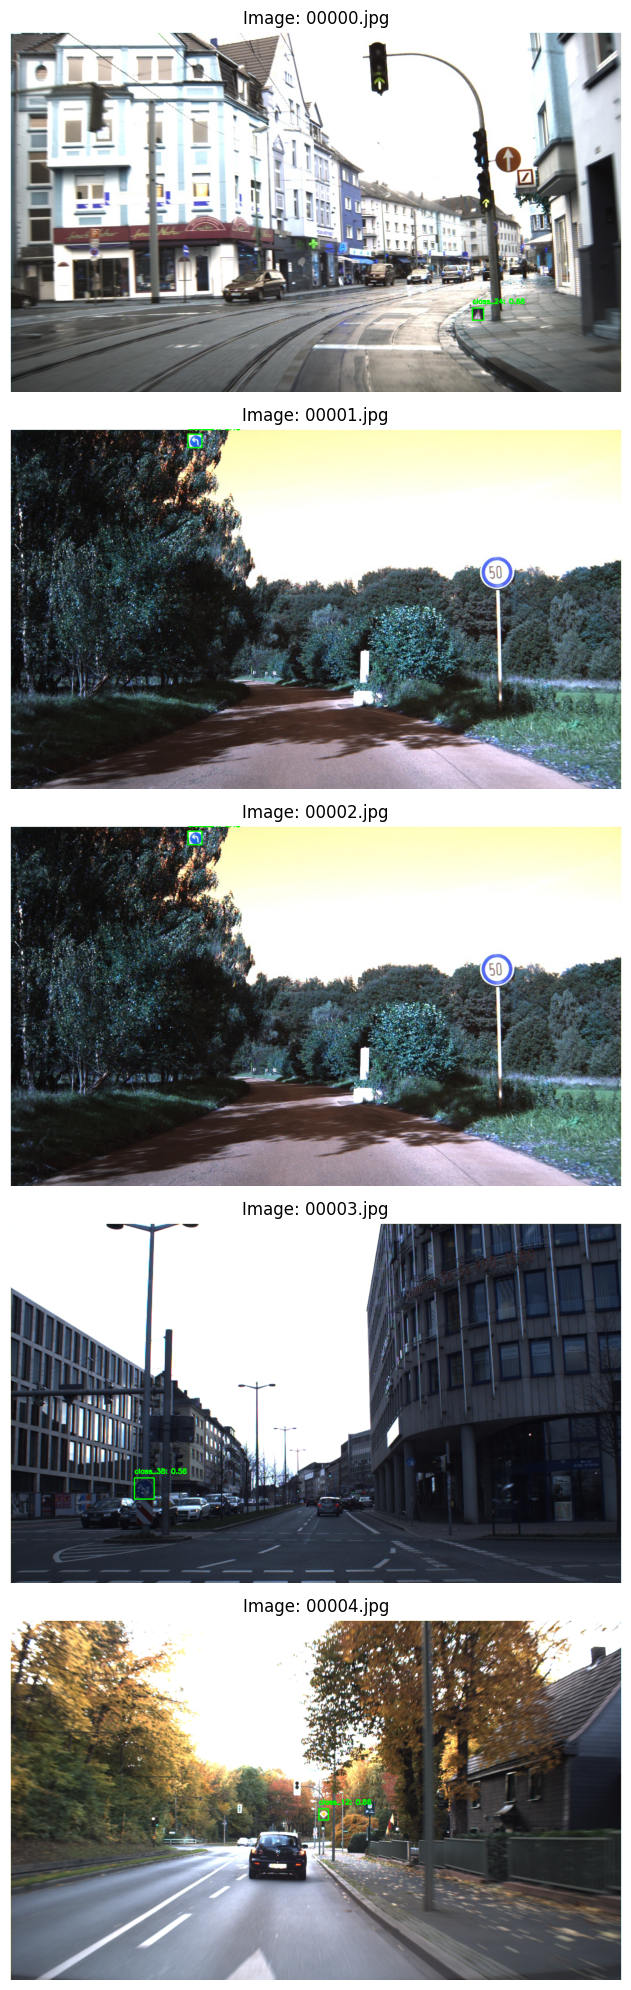


Generating comprehensive training visualizations...


In [ ]:
  # If you want to evaluate and visualize results
yolo_results = evaluate_detection_model(model, yaml_path)
print("\nGenerating comprehensive training visualizations...")


Generating comprehensive training visualizations...
Using results directory: runs/detect/train2
Using CSV file: runs/detect/train2/results.csv
Available metrics columns: ['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


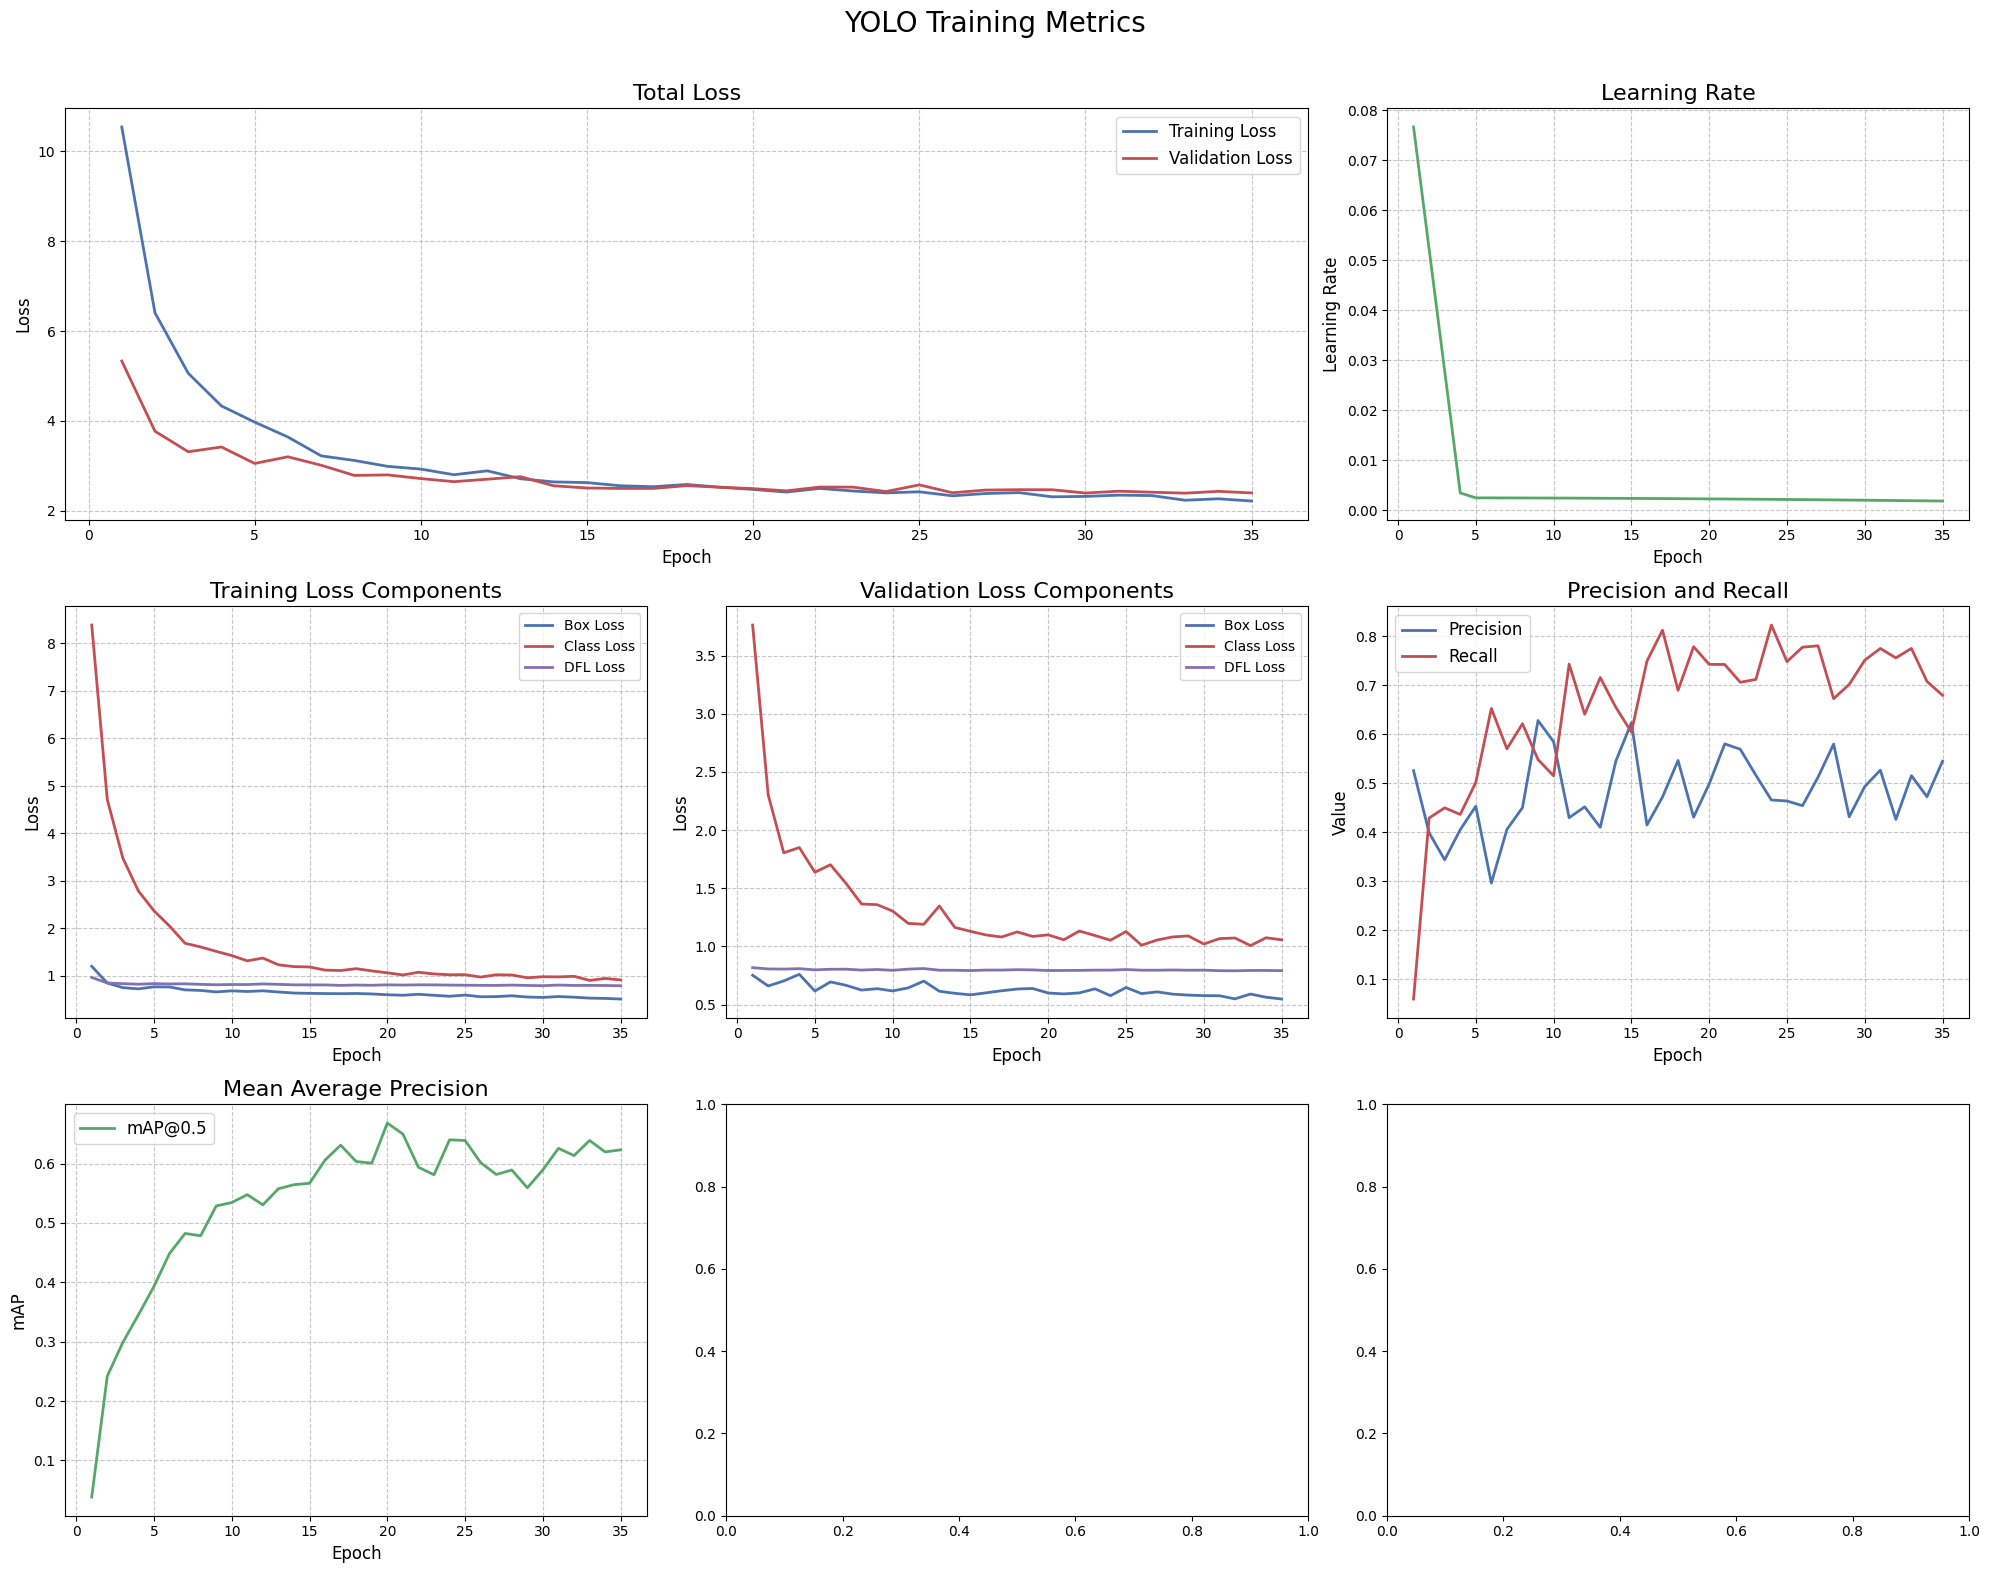

In [ ]:
print("\nGenerating comprehensive training visualizations...")
fig = visualize_training_metrics(model_type='yolo', run_dir='runs/detect/train2')
plt.show()

#8. Model Evaluation

Compare the performance of RT-DETR on the standard dataset vs. the standard + few-shots dataset.